In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.data_utils import construct_df, ohe_chars_stage, characters, stages, construct_df_igs, process_df_igs
from utils.modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model


## Base model

In [3]:
gs_5s_igs = pd.read_pickle('../saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('../saved_data/fp9_5s_igs.pkl')
p2019_5s_igs = pd.read_pickle('../saved_data/p2019_5s_igs.pkl')


In [4]:
prob_check = construct_df_igs(['../replays/mangozain.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
prob_check2 = construct_df_igs(['../replays/4stockp1.slp'],1)
prob_check2,all_diff_feats = process_df_igs(prob_check2)
prob_check3 = construct_df_igs(['../replays/test.slp'],1)
prob_check3,all_diff_feats = process_df_igs(prob_check3)
prob_check4 = construct_df_igs(['../replays/test2.slp'],1)
prob_check4,all_diff_feats = process_df_igs(prob_check4)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [71]:
df,features = process_df_igs(pd.concat([gs_5s_igs, fp9_5s_igs,p2019_5s_igs]).reset_index(drop=True))
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

X_train = df_train[features]
y_train = df_train['winner']

X_val = df_val[features]
y_val = df_val['winner']

X_test = df_test[features]
y_test = df_test['winner']

Training accuracy: 0.988
Training log loss: 0.091
Validation accuracy: 0.925
Validation log loss: 0.263


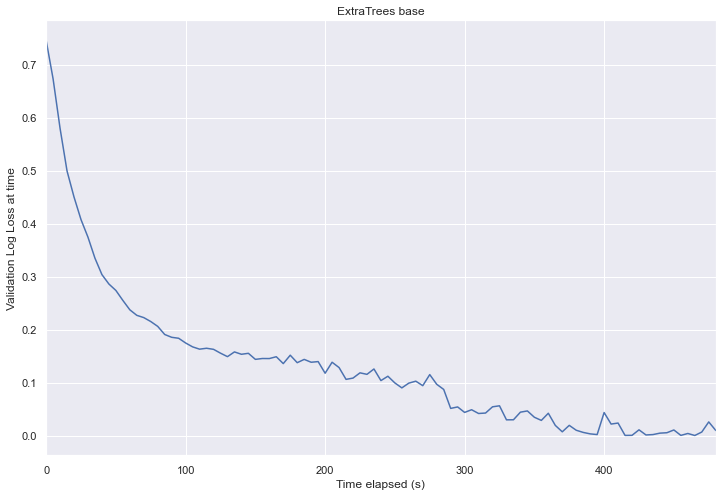

In [6]:
xt_base = ExtraTreesClassifier(random_state=0,ccp_alpha=.000001,max_features=5, min_samples_split=4 )
xt_base=validate_model(xt_base,X_train, y_train, X_val, y_val, xgb=False, title='ExtraTrees base')


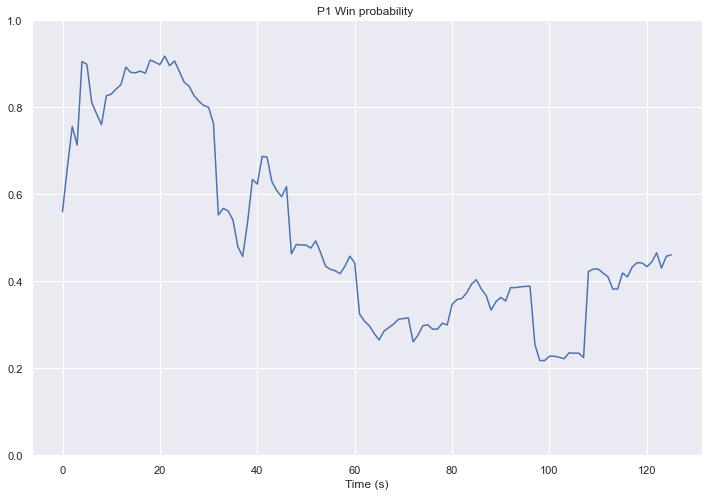

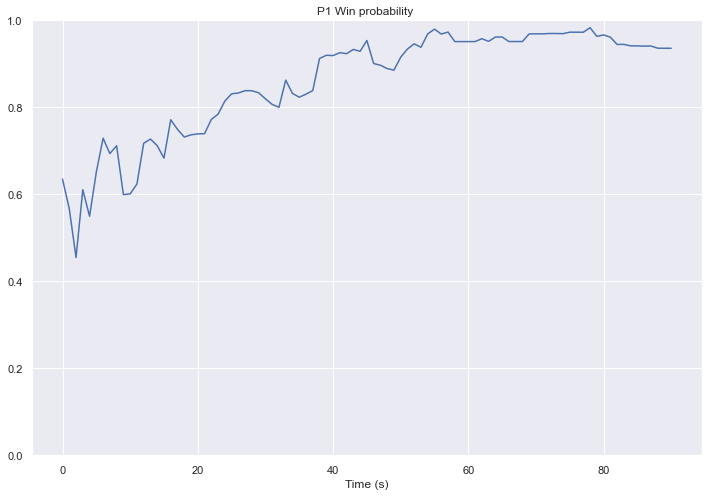

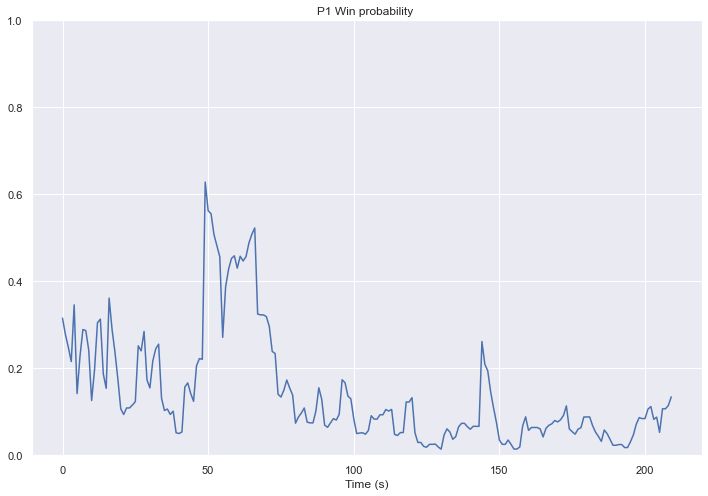

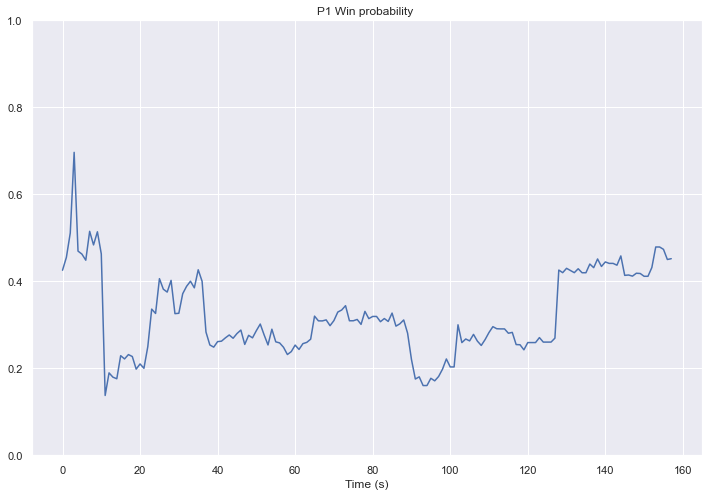

In [115]:
plot_win_probs(prob_check, xt_base, features)
plot_win_probs(prob_check2,xt_base, features)
plot_win_probs(prob_check3,xt_base, features)
plot_win_probs(prob_check4,xt_base, features)

## Noisy feature sets

In [124]:
def add_noise(df):
    df2 = df.copy()
    df2['frames_elapsed'] = df2['frames_elapsed']+np.random.normal(0, 300,len(df))
    df2['p1_damage'] = df2['p1_damage']+np.random.normal(0, 5,len(df))
    df2['p2_damage'] = df2['p2_damage']+np.random.normal(0, 5,len(df))
    df2['p1_total_hits'] = df2['p1_total_hits']+np.random.normal(0, 3,len(df))
    df2['p2_total_hits'] = df2['p2_total_hits']+np.random.normal(0, 3,len(df))
    return df2

def validate_model_noisy(model, X_train, y_train, X_val, y_val, xgb=False, title = ''):

    if xgb:
        eval_set = [(X_val, y_val)]
        model.fit( X_train, y_train, eval_set=eval_set,
                   eval_metric='error', early_stopping_rounds=50,verbose=False)
    else:
        model.fit(X_train,y_train)

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    y_pred_prob = model.predict_proba(X_val)
    ll = log_loss(y_val, y_pred_prob)


    y_pred_t = model.predict(X_train)
    acc_t = accuracy_score(y_train, y_pred_t)

    y_pred_prob_t = model.predict_proba(X_train)
    ll_t = log_loss(y_train, y_pred_prob_t)

    df = X_val.copy()
    #df['win_prob'] = y_pred_prob[:,1]
    #df['winner']   = y_val
    df['log_loss'] = get_log_losses(X_val,y_val, model)
    df['bin'] = pd.cut(df['frames_elapsed'],np.arange(97) *300 - 150)
    df= df.groupby(['bin'])[['log_loss']].mean().reset_index()

    plt.figure(figsize=(12,8))
    sns.lineplot(x=np.linspace(0,480,96), y=df['log_loss'])

    print('Training accuracy: {:.3f}'.format(acc_t))
    print('Training log loss: {:.3f}'.format(ll_t))

    print('Validation accuracy: {:.3f}'.format(acc))
    print('Validation log loss: {:.3f}'.format(ll))
    plt.ylabel('Validation Log Loss at time')
    plt.xlabel('Time elapsed (s)')
    plt.xlim((0,480))
    plt.title(title)
    plt.show()

    return model

Training accuracy: 1.000
Training log loss: 0.083
Validation accuracy: 0.923
Validation log loss: 0.268


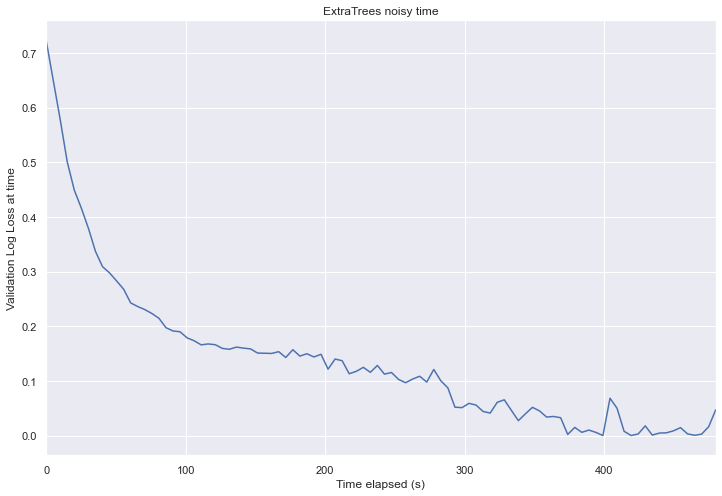

In [125]:
X_train_noisy = add_noise(X_train)
xt_noisy = ExtraTreesClassifier(random_state=0,ccp_alpha=.000001,max_features=5, min_samples_split=4 )
ll_df=validate_model_noisy(xt_noisy,X_train_noisy, y_train, X_val, y_val, xgb=False, title='ExtraTrees noisy time')


Doesn't seem like adding randomness to the features helps much. I did test with the smaller dataset and it seemed to make a difference there - most likely something I'll check back on later. For now I won't add noise I think.

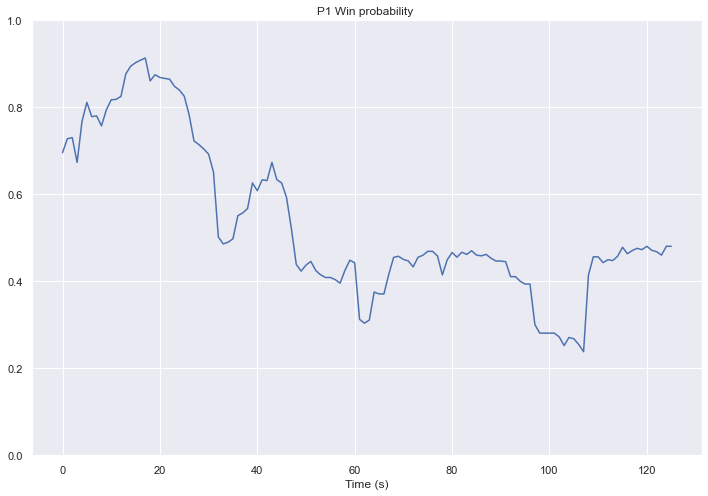

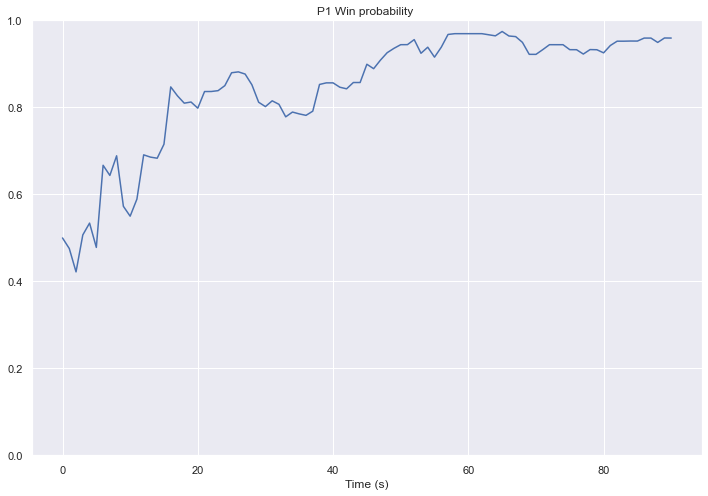

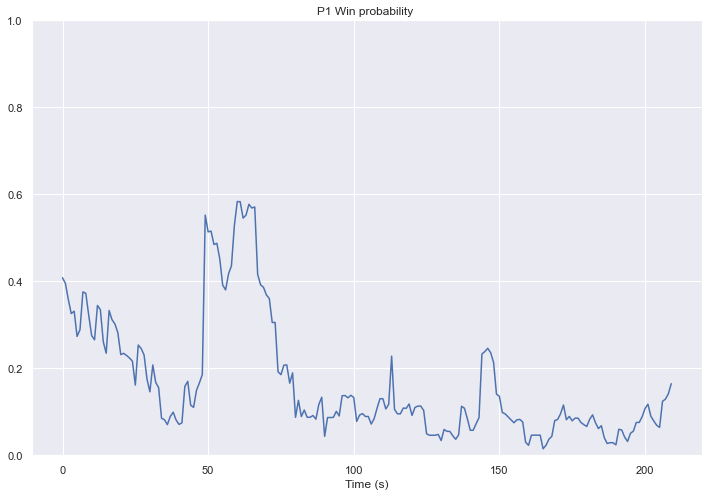

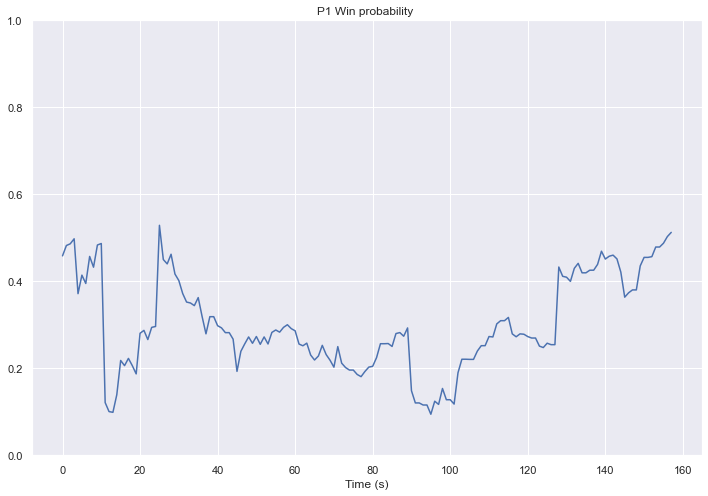

In [118]:
plot_win_probs(prob_check, xt_noisy, features)
plot_win_probs(prob_check2,xt_noisy, features)
plot_win_probs(prob_check3,xt_noisy, features)
plot_win_probs(prob_check4,xt_noisy, features)

## Feature subsets

In [69]:
def test_features_xt(feature_list, df, title):
    
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=4)
    
    X_train = df_train[feature_list]
    y_train = df_train['winner']
    
    X_val = df_val[feature_list]
    y_val = df_val['winner']
    
    model = validate_model(ExtraTreesClassifier(n_jobs=-1,ccp_alpha=.000001,max_features=5, min_samples_split=4),
                    X_train, y_train,X_val,y_val, xgb=False,title=title)
    
    return model

In [16]:
features

base = features[:5]

igs = features[5:23]

ohe = features[23:81]

calculated = features[81:]

p2_stats = ['p2_total_hits', 'p2_shield_frames', 'p2_early_stocks_lost', 'p2_ground_hits', 'p2_smash_hits', 'p2_aerial_hits','p2_grabs']

### Only basic features 

Training accuracy: 0.944
Training log loss: 0.190
Validation accuracy: 0.727
Validation log loss: 0.538


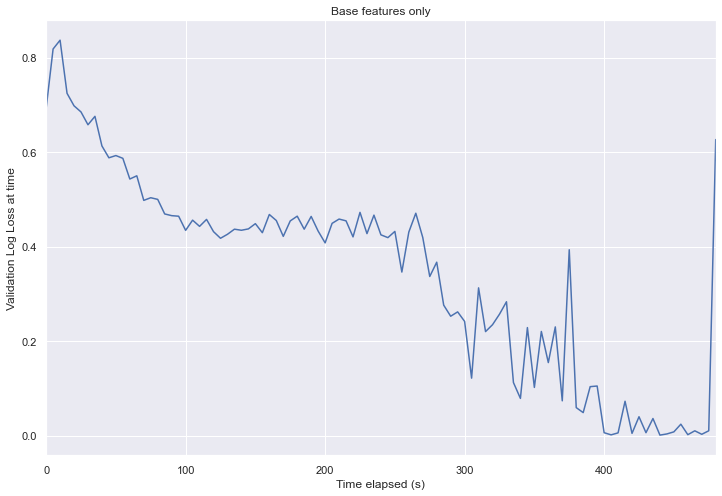

In [32]:
xt_b=test_features_xt(base, df, title='Base features only')

### Basic + ingame stats 

Training accuracy: 0.981
Training log loss: 0.092
Validation accuracy: 0.869
Validation log loss: 0.335


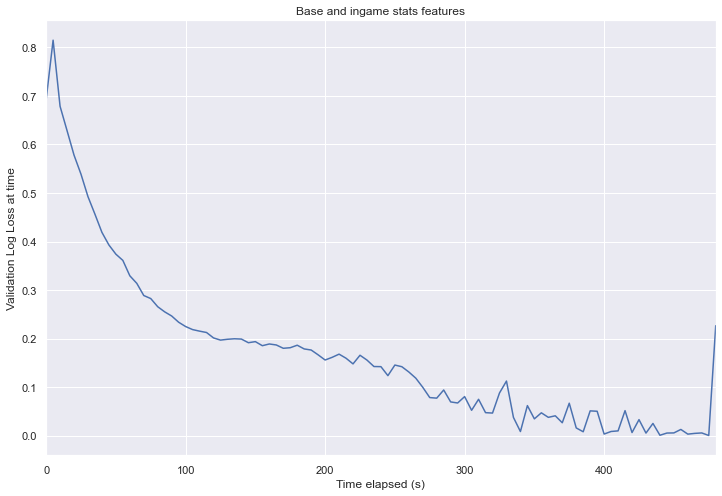

In [33]:
xt_bi=test_features_xt(base+igs, df, title='Base and ingame stats features')

### Basic + one hot encoded characters and stages 

Training accuracy: 0.964
Training log loss: 0.179
Validation accuracy: 0.816
Validation log loss: 0.388


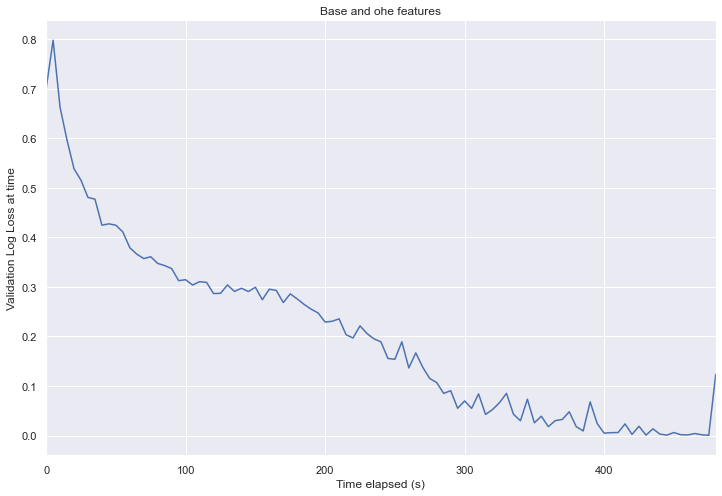

In [34]:
xt_bo=test_features_xt(base+ohe, df, title='Base and ohe features')

### Basic, one hot encoded, in game stats

Training accuracy: 0.987
Training log loss: 0.096
Validation accuracy: 0.934
Validation log loss: 0.251


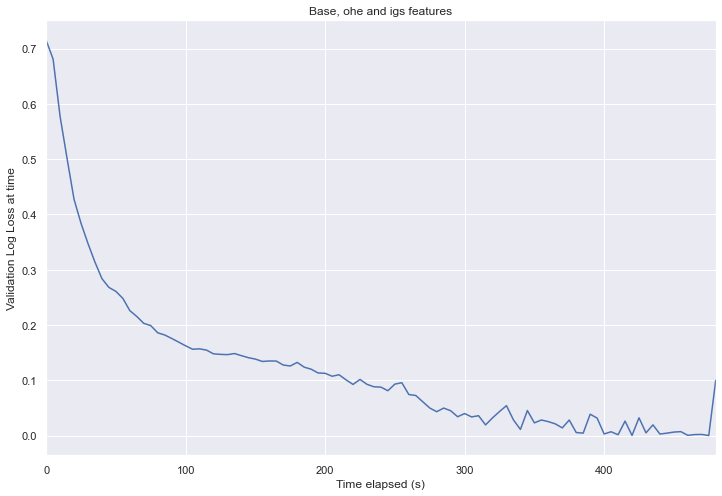

In [35]:
xt_boi=test_features_xt(base+ohe+igs, df, title='Base, ohe and igs features')

### Basic, OHE, calculated stats 

Training accuracy: 0.986
Training log loss: 0.104
Validation accuracy: 0.921
Validation log loss: 0.245


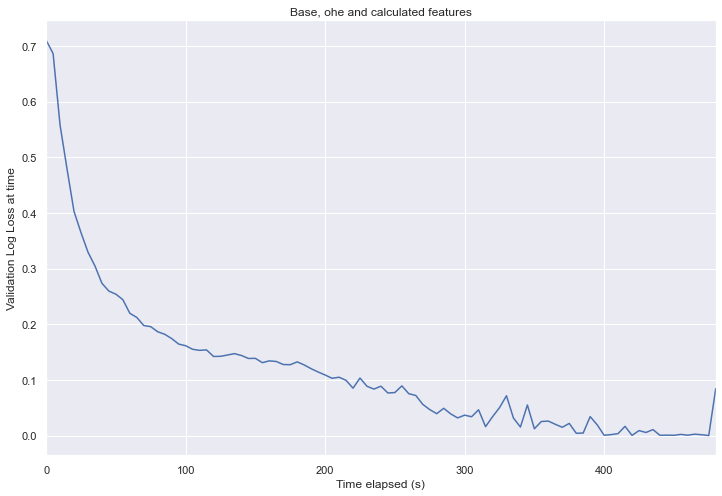

In [36]:
xt_boc=test_features_xt(base+ohe+calculated, df, title='Base, ohe and calculated features')

### Base, OHE, p1 stats, calculated stats 

Training accuracy: 0.987
Training log loss: 0.097
Validation accuracy: 0.928
Validation log loss: 0.250


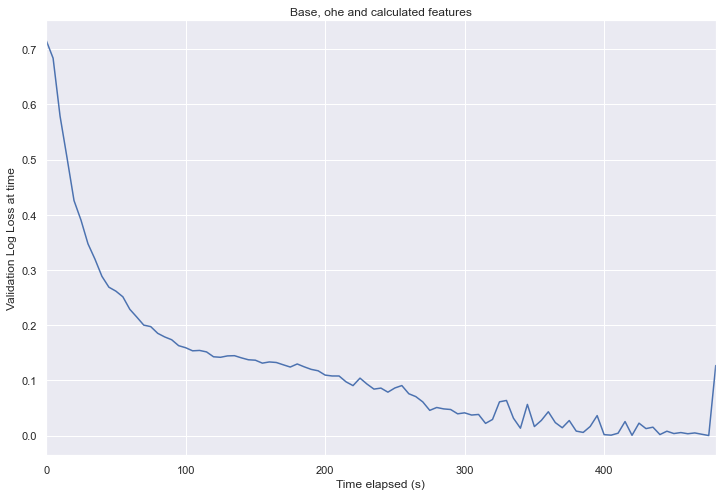

In [52]:
p2_stats = ['p2_total_hits', 'p2_shield_frames', 'p2_early_stocks_lost',
            'p2_ground_hits', 'p2_smash_hits', 'p2_aerial_hits','p2_grabs', 'p2_rolls']
p1_stats = [f for f in igs if f not in p2_stats]
xt_bop1c=test_features_xt(base+ohe+p1_stats+calculated, df, title='Base, ohe and calculated features')

Like we saw with RF, the main improvement to performance comes from including in game stats. All the variations of the in game stats perform similarly, but it seems like only including the p1 stats and the calculated stats gives good LL and accuracy. Again, the differences here are all small.

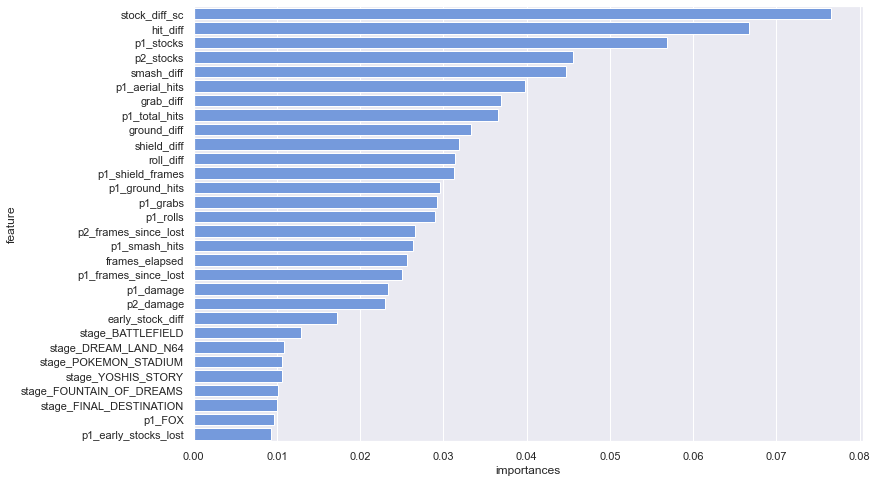

In [53]:
plot_feature_importances(xt_bop1c, base+ohe+p1_stats+calculated, 30)

### Basic, ohe, ingame stats, selected diff stats

Training accuracy: 0.988
Training log loss: 0.092
Validation accuracy: 0.933
Validation log loss: 0.242


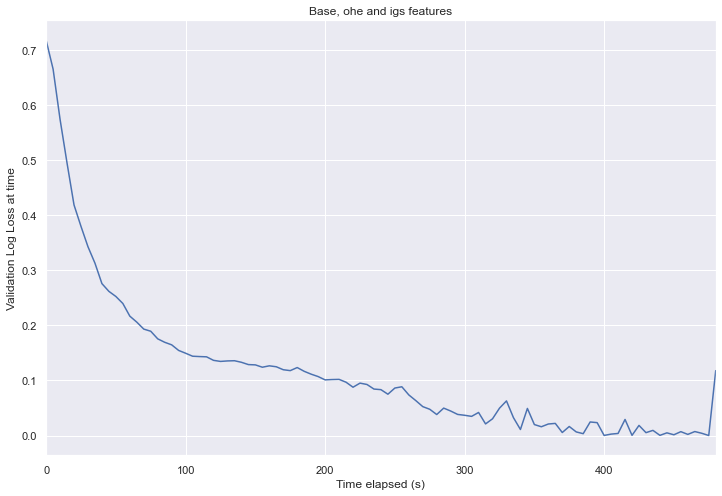

In [63]:
xt_boi_sel=test_features_xt(base+ohe+igs+['stock_diff_sc', 'hit_diff','shield_diff', 'early_stock_diff'], df, title='Base, ohe and igs features')

In [55]:
calculated

['hit_diff',
 'shield_diff',
 'early_stock_diff',
 'ground_diff',
 'smash_diff',
 'aerial_diff',
 'grab_diff',
 'roll_diff',
 'stock_diff_sc']

Training accuracy: 0.988
Training log loss: 0.090
Validation accuracy: 0.933
Validation log loss: 0.240


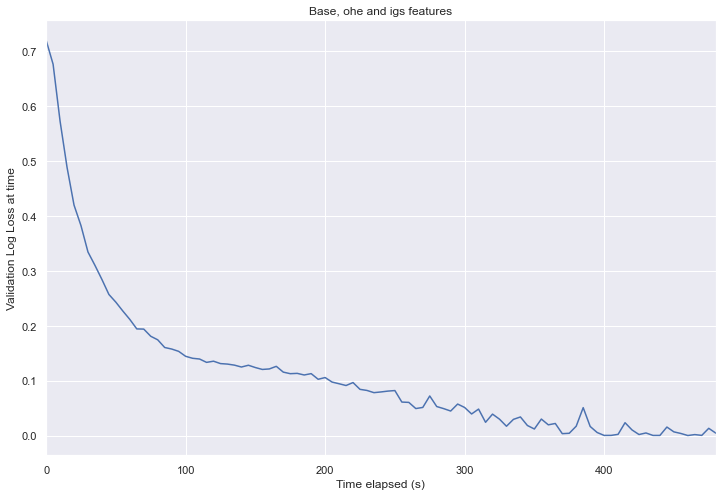

In [70]:
xt_boi_sel=test_features_xt(base+ohe+igs+['stock_diff_sc', 'hit_diff','shield_diff', 'early_stock_diff', 'grab_diff'], df, title='Base, ohe and igs features')

Tested a few variations, this seems to be the best by a small margin. Overall doing this did bring up the LL performance by around 8%, which isn't nothing. I'll go with this feature set from now on